# Convolutional Neural Network Image Classification Project

In [141]:
# Import our dependencies
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Generate a tf.data.Dataset

In [142]:
base_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

### List the folders to see their arrangement

In [143]:
os.listdir(base_dir)

['test', 'train', 'valid']

### Create train, test and validation datasets

In [144]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(200, 200),
batch_size=32)

Found 613 files belonging to 4 classes.


In [145]:
testing_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(200, 200),
batch_size=32)

Found 315 files belonging to 4 classes.


In [146]:
valid_set = tf.keras.preprocessing.image_dataset_from_directory(
valid_dir,
seed=101,
image_size=(200, 200),
batch_size=32)

Found 72 files belonging to 4 classes.


## Early Stopping

In [147]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
             EarlyStopping(patience=20)
]

## Data Augmentation

In [148]:
data_augmentation = tf.keras.Sequential(
  [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(200,200,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),]
)

## Build CNN

In [149]:
model = Sequential([
    #data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='softmax')
])

### Compile Model

In [155]:
model.compile(optimizer='adam',
              #loss=keras.losses.BinaryCrossentropy(from_logits=True),
              loss=keras.losses.CategoricalCrossentropy(),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              #loss=keras.losses.mse,
              metrics=[keras.metrics.Accuracy()])

### Train the model

In [156]:
history = model.fit(training_set,validation_data=valid_set, epochs=600,callbacks=callbacks)

Epoch 1/600


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 3s 102ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_loss: 0.0000e+00 - val_accuracy: 0.2917
Epoch 2/600
20/20 [==============================] - 2s 93ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_loss: 0.0000e+00 - val_accuracy: 0.2917
Epoch 3/600
20/20 [==============================] - 2s 92ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_loss: 0.0000e+00 - val_accuracy: 0.2917
Epoch 4/600
20/20 [==============================] - 2s 96ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_loss: 0.0000e+00 - val_accuracy: 0.2917
Epoch 5/600
20/20 [==============================] - 2s 91ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_loss: 0.0000e+00 - val_accuracy: 0.2917
Epoch 6/600
20/20 [==============================] - 2s 91ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_loss: 0.0000e+00 - val_accuracy: 0.2917
Epoch 7/600
20/20 [==============================] - 2s 92ms/step - loss: 0.0000e+00 - accuracy: 0.1876 - val_l

# Model attempt 2: use notebook from kaggle as inspiration


link: https://www.kaggle.com/code/prthmgoyl/ensemblemodel-ctscan

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [36]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [37]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    #class_mode= 'categorical'
    #class_mode='sparse'
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode='categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode='categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode='categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [38]:
# Get Dataframes
base_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data'
train_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data/train'
test_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data/valid'
valid_dir = 'C:/Users/schre/OneDrive/Documents/Python/Data/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 613 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [39]:
train_df

,filepaths,labels
0,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
2,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
3,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
4,C:/Users/schre/OneDrive/Documents/Python/Data/...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
...,...,...
608,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
609,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
610,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
611,C:/Users/schre/OneDrive/Documents/Python/Data/...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


## First pass at base CNN model

In [40]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Create convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [41]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 52, 52, 64)        36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 5632

In [42]:
# Add dense layers to finish model 
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [43]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 52, 52, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 173056)           

In [44]:
train_gen.labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True
                  ),
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen, epochs=100, 
                    validation_data=(test_gen))

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "c:\Users\schre\anaconda3\envs\dev\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\schre\anaconda3\envs\dev\lib\runpy.py", line 86, in _run_code

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\schre\anaconda3\envs\dev\lib\asyncio\base_events.py", line 603, in run_forever

  File "c:\Users\schre\anaconda3\envs\dev\lib\asyncio\base_events.py", line 1909, in _run_once

  File "c:\Users\schre\anaconda3\envs\dev\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\schre\AppData\Local\Temp\ipykernel_26604\1848037055.py", line 8, in <module>

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [40,4] and labels shape [160]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_332211]

## First pass at pretrained model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, 
                                                  weights="imagenet", 
                                                  input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.5710
Epoch 1: val_accuracy improved from -inf to 0.63175, saving model to best_model.h5
16/16 [==============================] - 15s 731ms/step - loss: 1.1775 - accuracy: 0.5710 - val_loss: 1.1289 - val_accuracy: 0.6317


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7977
Epoch 2: val_accuracy did not improve from 0.63175
16/16 [==============================] - 9s 546ms/step - loss: 0.5194 - accuracy: 0.7977 - val_loss: 1.5174 - val_accuracy: 0.5841
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8777
Epoch 3: val_accuracy improved from 0.63175 to 0.64444, saving model to best_model.h5
16/16 [==============================] - 9s 583ms/step - loss: 0.3598 - accuracy: 0.8777 - val_loss: 0.8799 - val_accuracy: 0.6444
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8989
Epoch 4: val_accuracy improved from 0.64444 to 0.70794, saving model to best_model.h5
16/16 [==============================] - 9s 596ms/step - loss: 0.2628 - accuracy: 0.8989 - val_loss: 0.8763 - val_accuracy: 0.7079
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.9005
Epoc

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 830ms/step - loss: 0.4806 - accuracy: 0.8611
Train Loss:  0.00021428987383842468
Train Accuracy:  1.0
--------------------
Validation Loss:  1.1444604396820068
Validation Accuracy:  0.7250000238418579
--------------------
Test Loss:  0.4806223511695862
Test Accuracy:  0.8611111044883728


In [16]:
from tensorflow.keras.applications import ResNet50

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.2061 - accuracy: 0.6558
Epoch 1: val_accuracy improved from -inf to 0.63810, saving model to best_model_resnet.h5
16/16 [==============================] - 13s 754ms/step - loss: 1.2061 - accuracy: 0.6558 - val_loss: 1.9543 - val_accuracy: 0.6381
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9070
Epoch 2: val_accuracy did not improve from 0.63810
16/16 [==============================] - 11s 694ms/step - loss: 0.2639 - accuracy: 0.9070 - val_loss: 3.2417 - val_accuracy: 0.4921
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9608
Epoch 3: val_accuracy did not improve from 0.63810
16/16 [==============================] - 11s 705ms/step - loss: 0.1192 - accuracy: 0.9608 - val_loss: 1.7608 - val_accuracy: 0.6000
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9690
Epoch 4: val_accuracy improved f

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 976ms/step - loss: 0.4954 - accuracy: 0.8750
Train Loss:  0.00044671836076304317
Train Accuracy:  1.0
--------------------
Validation Loss:  0.9063888788223267
Validation Accuracy:  0.800000011920929
--------------------
Test Loss:  0.4954267740249634
Test Accuracy:  0.875


In [18]:
from tensorflow.keras.applications import InceptionV3
# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained InceptionV3 model
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_inceptionv3.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.9437 - accuracy: 0.4976
Epoch 1: val_accuracy improved from -inf to 0.17143, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 8s 393ms/step - loss: 1.9437 - accuracy: 0.4976 - val_loss: 25.6758 - val_accuracy: 0.1714
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.2094 - accuracy: 0.6819
Epoch 2: val_accuracy did not improve from 0.17143
16/16 [==============================] - 5s 333ms/step - loss: 1.2094 - accuracy: 0.6819 - val_loss: 16.2365 - val_accuracy: 0.1714
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.7357
Epoch 3: val_accuracy improved from 0.17143 to 0.33333, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 6s 354ms/step - loss: 0.8410 - accuracy: 0.7357 - val_loss: 4.0005 - val_accuracy: 0.3333
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.7314 

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_inceptionv3.h5')


ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 554ms/step - loss: 0.9546 - accuracy: 0.7083
Train Loss:  0.02602335810661316
Train Accuracy:  1.0
--------------------
Validation Loss:  1.9285609722137451
Validation Accuracy:  0.550000011920929
--------------------
Test Loss:  0.9546170830726624
Test Accuracy:  0.7083333134651184


In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

input_shape=img_shape

model_inceptionv3 = load_model('best_model_inceptionv3.h5')
model = load_model('best_model.h5')
model_resnet = load_model('best_model_resnet.h5')

# Create input layer
input_layer = Input(shape=(input_shape))  # Replace input_shape with the appropriate shape for your models

# Get outputs from all three models
output_inceptionv3 = model_inceptionv3(input_layer)
output_model = model(input_layer)
output_resnet = model_resnet(input_layer)

# Average the predictions from all three models
average = Average()([output_inceptionv3, output_model, output_resnet])

# Create an ensemble model
ensemble_model = Model(inputs=input_layer, outputs=average)

# Save the ensemble model
ensemble_model.save('final_ensemble_model.h5')

In [21]:
model = load_model('final_ensemble_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\schre\AppData\Local\Temp\ipykernel_26604\2064879440.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 1 1 3 1 3 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 3 3 3 0 3 3 3 3 3 3 3 3 3]


In [23]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('final_ensemble_model.h5')

# Compile the model
# Replace 'optimizer' and 'loss' with your chosen optimizer and loss function
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Assuming you've defined test_gen and test_df
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

1/1 [==============================] - 5s 5s/step - loss: 0.3838 - accuracy: 0.9028
Test Loss: 0.38379716873168945
Test Accuracy: 0.9027777910232544


In [24]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[22  0  0  1]
 [ 2 17  0  2]
 [ 0  0 13  0]
 [ 2  0  0 13]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.85      0.96      0.90        23
   large-cell-carcinoma       1.00      0.81      0.89        21
                 normal       1.00      1.00      1.00        13
squamous-cell-carcinoma       0.81      0.87      0.84        15

               accuracy                           0.90        72
              macro avg       0.91      0.91      0.91        72
           weighted avg       0.91      0.90      0.90        72



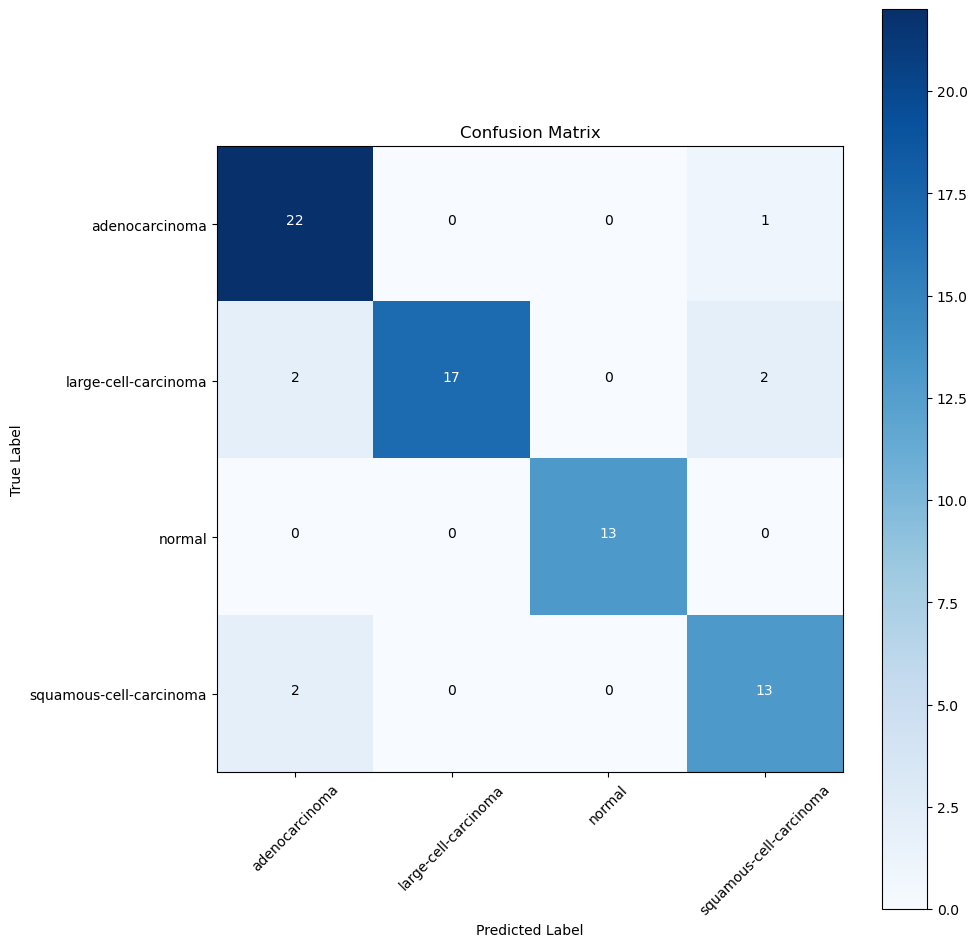

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))